<a href="https://colab.research.google.com/github/vhstavares/Consultor-de-Mudas-/blob/main/prototipo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [12]:
import os
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

##Puxando dataset do driver

In [3]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
train_dir = "/content/drive/MyDrive/tcc/arquivos/train"
ROTULOS = ['CARAIBA','GUARITA','IPE_AMARELO']

In [5]:
totalTreino = 100
train_img = []
for train in os.listdir(train_dir):
  train_muda = [train_dir+"/"+train+"/"+img for img in os.listdir(train_dir+"/"+train)]
  train_img += train_muda[:totalTreino]

##Lendo os dados
Imagens de 3 especies diferentes: Caraiba(Valor 0), Ipê Amarelo(Valor 1) e Guarita(Valor 2)

# Converter Imagem

In [24]:
from google.colab.patches import cv2_imshow

def convertImagem(imagem):
    brightness = 10
    contrast = 30
    img = np.int16(imagem)
    img = img * (contrast/127+1) - contrast + brightness
    img = np.clip(img, 0, 255)
    img = np.uint8(img)

    (r, g, b) = cv2.split(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    retorno = cv2.merge([gray, g, gray])
    #cv2_imshow(retorno)
    return retorno

# Ler Imagem

In [7]:
def ler_imagens(lista_de_imagens):
    """
    Retorna dois arrays: 
       um será as imagens e o outro seus respectivos rotulos
    """
    imagens = [] # images
    rotulos = [] # labels
    
    for image in lista_de_imagens:
        #Lendo a imagem com as dimensões de 180 por 120
        imagem = cv2.resize(
            cv2.imread(image, cv2.IMREAD_COLOR), (180,120), 
            interpolation=cv2.INTER_CUBIC)
        
        imagem = convertImagem(imagem)

        imagens.append(imagem)

        #Pegando os rotulos
        rotulo = ROTULOS.index(str(image).split('/')[7])
        rotulos.append(rotulo)

    return imagens, rotulos

#Lendo Imagens e rótulos

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Rótulos para mudas:')

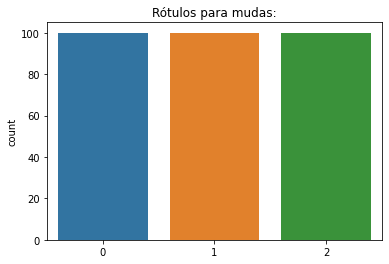

In [8]:
treinoX, treinoY = ler_imagens(lista_de_imagens=train_img)
treinoX = np.array(treinoX)
treinoY = np.array(treinoY)

#Plota o grafico com a quantidade de cada label
sns.countplot(treinoY)
plt.title('Rótulos para mudas:')

# Separando dados de treino e teste

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(treinoX, treinoY, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (240, 120, 180, 3)
Shape of validation images is: (60, 120, 180, 3)
Shape of labels is: (240,)
Shape of labels is: (60,)


# Gerando Modelo

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Sequential

num_classes = 3

model = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(64, (3, 3), activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(128, (3, 3),  activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(128, (3, 3),  activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),

  layers.Flatten(),

  layers.Dense(512, activation='relu'),
  
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
ntrain = len(X_train)
nval = len(X_val)
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1./255,   
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  

#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
Epocas = 10
historico = model.fit_generator(train_generator, 
                                steps_per_epoch=ntrain // batch_size, 
                                epochs=Epocas, 
                                validation_data=val_generator, 
                                validation_steps=nval // batch_size)

# Analisando Acurácia e Perdas

**Acurácia por épocas**

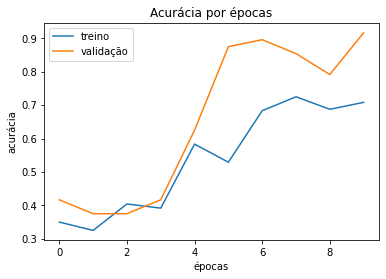

In [22]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title('Acurácia por épocas')
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])

**Perdas por épocas**

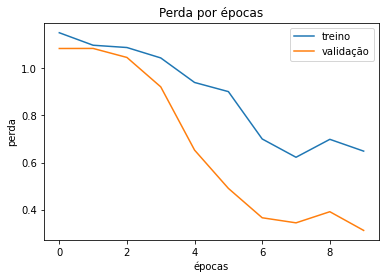

In [23]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('Perda por épocas')
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])